## Dyslexia detection using eeg brain wave signals

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import timeit

[Kaggle Data set](https://www.kaggle.com/datasets/wanghaohan/confused-eeg)

These data are collected from ten students, each watching ten videos. Therefore, it can be seen as only 100 data points for these 12000+ rows. If you look at this way, then each data point consists of 120+ rows, which is sampled every 0.5 seconds (so each data point is a one minute video). Signals with higher frequency are reported as the mean value during each 0.5 second.

- connection of dyslexia and EEG signals is not clear, but we can try to find some patterns in the data set and try to predict if a person is dyslexic or not.
- This dataset is for confusion detection using EEG signals.
- if you are wondering What does confusion have anything to do with Dyslexia?
- confusion is a common symptom of dyslexia. Dyslexic people often have trouble with reading, writing, and spelling. They may also have trouble with math, following directions, and distinguishing left from right.

### Taking data N dimensional samples

In [120]:
df = pd.read_csv('../EEG_data.csv')
data=pd.read_csv('../demographic_info.csv')
df.shape

(12811, 15)

renaming the features for easy to use (like in original dataset have some unnecessary space) and joining the dataset 

In [121]:
data = data.rename(columns = {'subject ID': 'SubjectID',' gender':'gender',' age':'age',' ethnicity':'ethnicity'})
df = df.merge(data,how = 'inner',on = 'SubjectID')
df.shape

(12811, 18)

In [122]:
df.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln,age,ethnicity,gender
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0,25,Han Chinese,M
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0,25,Han Chinese,M
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0,25,Han Chinese,M
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0,25,Han Chinese,M
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0,25,Han Chinese,M


### Further processing we need to know our dataset, its features and some basic information about it.

In [123]:
df.columns

Index(['SubjectID', 'VideoID', 'Attention', 'Mediation', 'Raw', 'Delta',
       'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2',
       'predefinedlabel', 'user-definedlabeln', 'age', 'ethnicity', 'gender'],
      dtype='object')

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12811 entries, 0 to 12810
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SubjectID           12811 non-null  float64
 1   VideoID             12811 non-null  float64
 2   Attention           12811 non-null  float64
 3   Mediation           12811 non-null  float64
 4   Raw                 12811 non-null  float64
 5   Delta               12811 non-null  float64
 6   Theta               12811 non-null  float64
 7   Alpha1              12811 non-null  float64
 8   Alpha2              12811 non-null  float64
 9   Beta1               12811 non-null  float64
 10  Beta2               12811 non-null  float64
 11  Gamma1              12811 non-null  float64
 12  Gamma2              12811 non-null  float64
 13  predefinedlabel     12811 non-null  float64
 14  user-definedlabeln  12811 non-null  float64
 15  age                 12811 non-null  int64  
 16  ethn

replacing string values with integer values and dropping the meaningless features

In [125]:
df['gender']=df['gender'].replace({'M':1,'F':0})
df['ethnicity']=df['ethnicity'].replace({'Han Chinese':0,'Bengali':1,'English':2})

/tmp/ipykernel_1850/2143383757.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gender']=df['gender'].replace({'M':1,'F':0})
/tmp/ipykernel_1850/2143383757.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['ethnicity']=df['ethnicity'].replace({'Han Chinese':0,'Bengali':1,'English':2})


In [126]:
df['user-definedlabeln'].value_counts()

user-definedlabeln
1.0    6567
0.0    6244
Name: count, dtype: int64

In [127]:
from sklearn.feature_selection import mutual_info_classif

In [128]:
y=df['user-definedlabeln']
mi_score=mutual_info_classif(df.drop('user-definedlabeln',axis=1),y,random_state=0)
mi_score=pd.Series(mi_score,index=df.drop('user-definedlabeln',axis=1).columns)
mi_score=(mi_score*100).sort_values(ascending=False)
mi_score

VideoID            6.473586
Alpha2             2.574662
Gamma1             2.476642
Delta              2.428097
Attention          2.211753
Theta              2.148097
Beta1              2.120132
Alpha1             2.013964
Gamma2             1.751776
Beta2              1.176536
Mediation          0.933126
SubjectID          0.915330
Raw                0.877649
predefinedlabel    0.118327
age                0.000000
ethnicity          0.000000
gender             0.000000
dtype: float64

In [129]:
mi_score.head(14).index

Index(['VideoID', 'Alpha2', 'Gamma1', 'Delta', 'Attention', 'Theta', 'Beta1',
       'Alpha1', 'Gamma2', 'Beta2', 'Mediation', 'SubjectID', 'Raw',
       'predefinedlabel'],
      dtype='object')

defining the target

In [130]:
df.drop(columns = ['SubjectID','predefinedlabel'],inplace=True)

In [131]:
target=df['user-definedlabeln']

pandas `corrwith` function is used to find the  linear relationship between the features and the target

<Axes: title={'center': 'Correlation with Target'}>

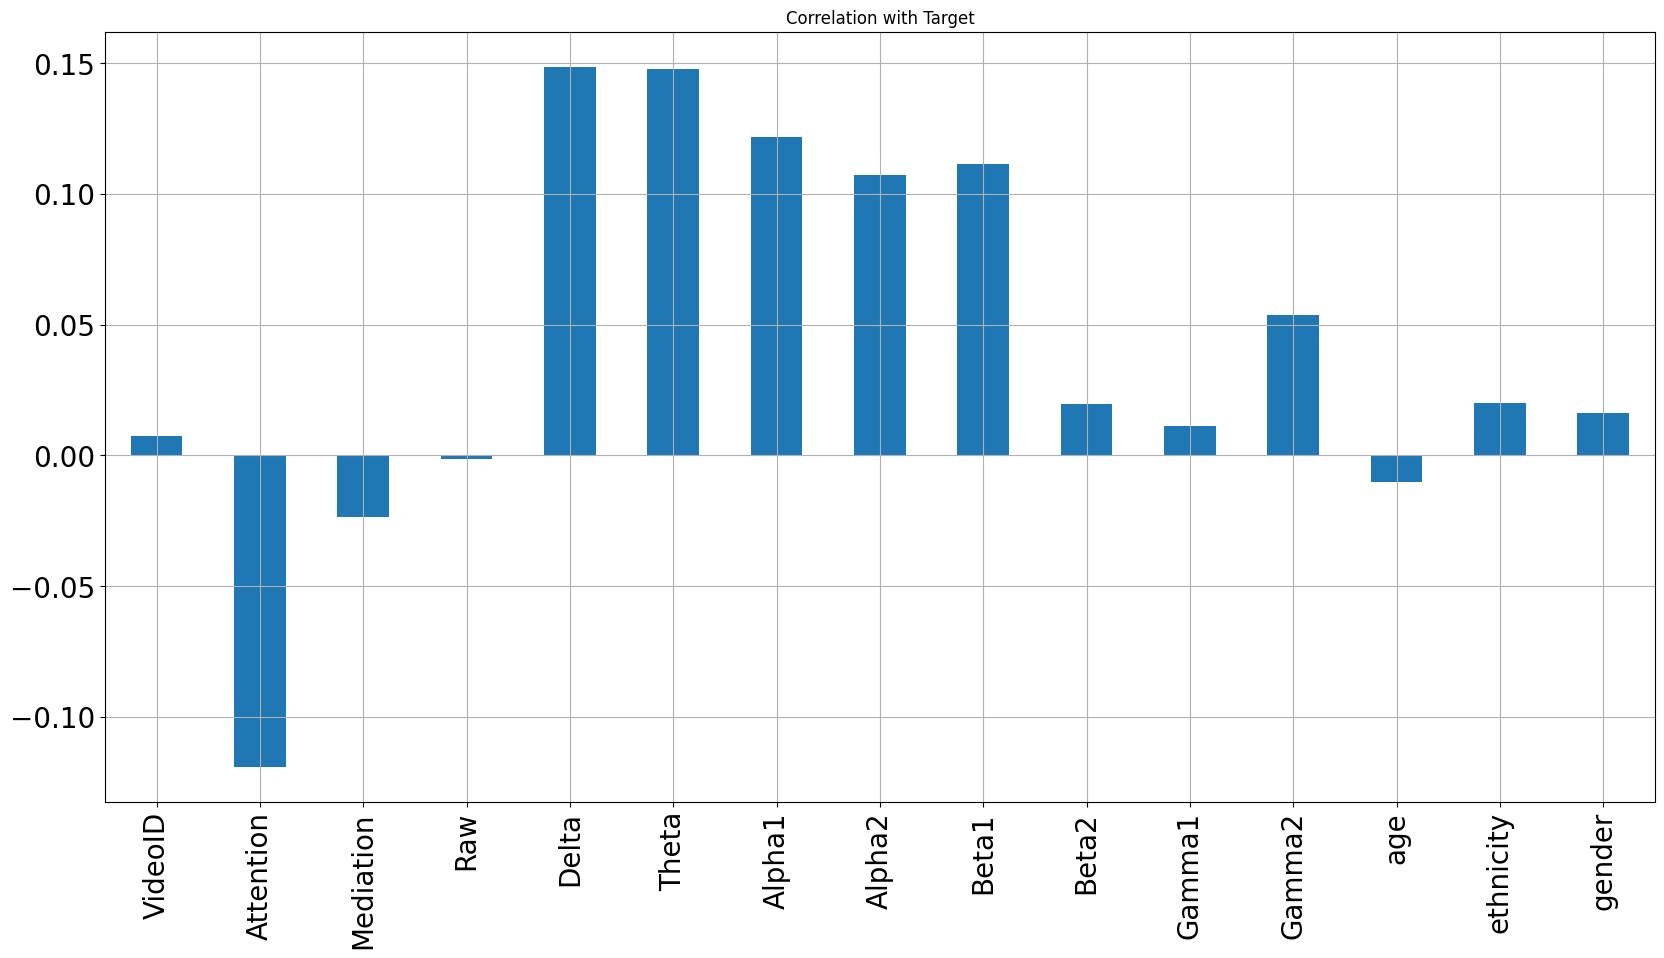

In [132]:
X= df.drop(columns = ['user-definedlabeln'])
X.corrwith(df['user-definedlabeln']).plot.bar(
        figsize = (20, 10), title = "Correlation with Target", fontsize = 20,
        rot = 90, grid = True)

### PCA using Using Sklearn

In [133]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X)

In [134]:
# Let's say, components = 5
n_components = 3
pca = PCA(n_components=3)

x_pca = pca.fit_transform(data_scaled)

# Create the dataframe
df_pca1 = pd.DataFrame(x_pca,
					columns=['PC{}'.
					format(i+1)
						for i in range(n_components)])
print(df_pca1)

            PC1       PC2       PC3
0     -0.232405  0.377468 -0.390625
1     -1.049482  0.476492 -1.137571
2      1.952919 -0.402292  0.779804
3      0.727933 -0.521705 -0.078135
4      1.404246 -0.185776  0.330448
...         ...       ...       ...
12806 -1.003399 -0.681178 -0.885436
12807  4.351528 -0.359415  1.122954
12808 -0.180188 -1.319107 -0.612241
12809 -0.921663 -0.834957 -1.064469
12810  3.770329 -1.209506  0.753606

[12811 rows x 3 columns]


In [135]:
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

Explained Variance Ratio: [0.31791464 0.11633255 0.108589  ]


### Division the dataset into training and testing set

In [136]:
from sklearn.model_selection import train_test_split

In [137]:
y=df['user-definedlabeln']
X_train,x_test,Y_train,y_test=train_test_split(df_pca1,y,random_state=108,test_size=0.27)

### ML algorithm SVM

In [138]:
from sklearn.svm import SVC

In [139]:
svm_classifier = SVC(random_state=108)

# Train the classifier on the training data
svm_classifier.fit(X_train, Y_train)

SVC(random_state=108)

### Trained classification model `svm_classifier`

In [140]:
predictions = svm_classifier.predict(x_test).astype(int)
predictions

array([0, 0, 1, ..., 0, 0, 0])

### accuracy of the model

In [141]:
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix,precision_score,recall_score,f1_score

In [142]:
accuracy = accuracy_score(y_test, predictions)
accuracy

0.627059843885516

### performance evaluation of the model

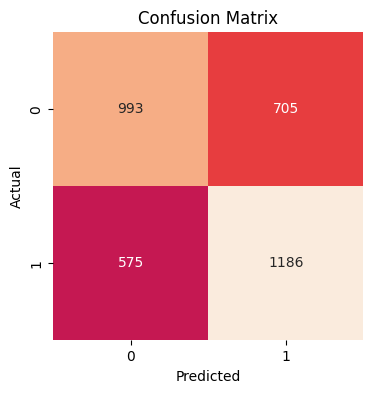

In [28]:
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(4, 4))

sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=False)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.show()

TP = True Positive<br>
TN = True Negative<br>
FP = False Positive<br>
FN = False Negative<br>

$ Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$

$ Precision = \frac{TP}{TP + FP} $<br>

$ Recall = \frac{TP}{TP + FN} $ <br>

$ F1 score = \frac{2×Precision×Recall}{Precision+Recall} $

In [29]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.63      0.58      0.61      1698
         1.0       0.63      0.67      0.65      1761

    accuracy                           0.63      3459
   macro avg       0.63      0.63      0.63      3459
weighted avg       0.63      0.63      0.63      3459



All dimensions pca svm

In [30]:
# for i in range(1,15):
# 	k=i
# 	pca = PCA(n_components=k)

# 	x_pca = pca.fit_transform(Z)

# 	# Create the dataframe
# 	df_pca1 = pd.DataFrame(x_pca,
# 						columns=['PC{}'.
# 						format(i+1)
# 							for i in range(k)])

# 	scaler = StandardScaler()
# 	X=scaler.fit_transform(df_pca1)

# 	y=df['user-definedlabeln']
# 	X_train,x_test,Y_train,y_test=train_test_split(X,y,random_state=108,test_size=0.27)
# 	start = timeit.default_timer()
# 	svm_classifier = SVC()

# 	# Train the classifier on the training data
# 	svm_classifier.fit(X_train, Y_train)

# 	predictions = svm_classifier.predict(x_test).astype(int)

# 	accuracy = accuracy_score(y_test, predictions)

# 	stop = timeit.default_timer()

# 	print("for k = ", k, "Accuracy is: ", accuracy, "Time taken: ", stop-start)

### using keras

In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks,layers

E0000 00:00:1730742566.291922   60870 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730742566.297082   60870 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Two hidden layers with 256 neurons each are added to the model. The activation function used is Rectified Linear Unit (ReLU), which is commonly used in hidden layers of neural networks.

In [32]:
model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(3,)),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

tb_callback = keras.callbacks.TensorBoard(log_dir="logs/", histogram_freq=1)

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy',keras.metrics.AUC(name='auc')]
             )
# The model is trained using the training data (X_train, Y_train) with a validation split of 20%, a batch size of 32, and training for 50 epochs. Additionally, a callback is used to reduce the learning rate on plateau during training.
batch_size=32
epochs=50
history=model.fit(
            X_train,
            Y_train,
            validation_split=0.2,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=[callbacks.ReduceLROnPlateau(),tb_callback]
)

Epoch 1/50


/home/animesh/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


223/234 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5746 - auc: 0.5908 - loss: 0.6818

KeyboardInterrupt: 

In [ ]:
model.evaluate(x_test,y_test)

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6280 - auc: 0.6795 - loss: 0.6400


[0.6388580799102783, 0.635732889175415, 0.6855908036231995]

In [ ]:
y_true = np.array(y_test)

y_pred = np.squeeze(model.predict(x_test))
y_pred = np.array(y_pred >=0.5, dtype=np.int64)
y_pred

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([0, 1, 1, ..., 0, 0, 0])

In [ ]:
accuracyKeras=accuracy_score(y_true, y_pred)
accuracyKeras

0.6357328707718994

In [ ]:
print("Precision:", precision_score(y_test, 
                                    y_pred, 
                                    average="weighted"))
  
print('Recall:', recall_score(y_test, 
                              y_pred, 
                              average="weighted"))

print('F1 score:', f1_score(y_test, y_pred, 
                            average="weighted"))

Precision: 0.6356559161344697
Recall: 0.6357328707718994
F1 score: 0.6355506070014614


In [35]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
for i in range(1,15):
	k=i
	pca = PCA(n_components=k)

	x_pca = pca.fit_transform(Z)

	# Create the dataframe
	df_pca1 = pd.DataFrame(x_pca,
						columns=['PC{}'.
						format(i+1)
							for i in range(k)])

	scaler = StandardScaler()
	X=scaler.fit_transform(df_pca1)

	y=df['user-definedlabeln']
	X_train,x_test,Y_train,y_test=train_test_split(X,y,random_state=108,test_size=0.27)
	
	inputs = tf.keras.Input(shape=(X_train.shape[1],))
	x = layers.Dense(256, activation='relu')(inputs)
	x = layers.Dense(256, activation='relu')(x)
	outputs = layers.Dense(1, activation='sigmoid')(x)

	model=keras.Model(inputs,outputs)
	model.compile(optimizer='adam',
				loss='binary_crossentropy',
				metrics=['accuracy',keras.metrics.AUC(name='auc')]
				)
	batch_size=32
	epochs=50
	history=model.fit(
				X_train,
				Y_train,
				validation_split=0.2,
				batch_size=batch_size,
				epochs=epochs,
				verbose=0,
				callbacks=[callbacks.ReduceLROnPlateau()]
	)
	start = timeit.default_timer()
	model.evaluate(x_test,y_test)

	y_true = np.array(y_test)
	y_pred = np.squeeze(model.predict(x_test))
	y_pred = np.array(y_pred >=0.5, dtype=np.int64)

	accuracyKeras=accuracy_score(y_true, y_pred)
	stop = timeit.default_timer()

	print("for k = ",k,"accuracy keras is: ",accuracyKeras,"time taken is: ",stop-start)

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5765 - auc: 0.5850 - loss: 0.6809
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
for k =  1 accuracy keras is:  0.5900549291702805 time taken is:  0.6353027879995352
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5952 - auc: 0.6405 - loss: 0.6582
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
for k =  2 accuracy keras is:  0.5981497542642382 time taken is:  0.5903989529997489
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6309 - auc: 0.6795 - loss: 0.6397
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
for k =  3 accuracy keras is:  0.6351546689794738 time taken is:  0.7808398779998242
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6578 - auc: 0.7095 - loss: 0.6192
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
for k =  4 accuracy keras is:  0.6608846487424112 time taken is:  0.6436961429990333
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6438 - auc: 0.7106 - loss: 0.6170
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
for k =  5